In [1]:
from keras import backend as K
from keras import initializers
from keras.models import Model
from keras.layers import Input, Dense,Activation,Dropout,Lambda
from keras.layers.embeddings import Embedding
from keras.layers import GRU
from keras.layers import Multiply,Reshape,multiply
from keras.layers.merge import Concatenate
from keras.layers.wrappers import Bidirectional
from keras.layers.noise import AlphaDropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize


from keras.models import model_from_json
from keras.callbacks import EarlyStopping,History,Callback

import pickle
import numpy as np
import random


import MeCab
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

/Users/svpcadmin/.pyenv/versions/3.6.4/envs/env3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def bootstrap(X,n):
    nums=np.arange(len(X))
    result=[]
    for i in range(n):
        np.random.shuffle(nums)
        result+=[X[nums[0]]]
    return result

def simple_sample_copy(X,y,train_num,test_num):
    dic={}
    for i,x in enumerate(X):
        dic[y[i]]=dic.get(y[i],[])+[x]

    test_X=[]
    test_y=[]
    train_X=[]
    train_y=[]
    for key in dic.keys():
        tmp=dic[key]
        np.random.shuffle(tmp)
        
        test_X+=tmp[:test_num]
        test_y+=[key]*test_num
        
        train_X+=bootstrap(tmp[test_num:],train_num)
        train_y+=[key]*train_num
    return np.array(train_X),np.array(test_X),np.array(train_y),np.array(test_y)


def data_reshape(x, L, max_sentence_length,dim):
    adjusted = np.zeros((len(x), L, max_sentence_length,dim), dtype=np.float)

    if L > 1:
        for i, sentences in enumerate(x):
            for j, sentence in enumerate(sentences[:L]):
                for k, word_vec in enumerate(sentence[:max_sentence_length]):
                    adjusted[i, j, k] = word_vec

    else:
        for i, sentence in enumerate(x):
            for k, word_vec in enumerate(sentence[:max_sentence_length]):
                adjusted[i, 0, k] = word_vec

    return adjusted

In [2]:
train_data=fetch_20newsgroups('train')
test_data=fetch_20newsgroups('test')

In [3]:
train_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [4]:
X_train_str=[word_tokenize(s) for s in tqdm.tqdm(train_data.data)]
y_train=train_data.target

100%|██████████| 11314/11314 [00:34<00:00, 327.50it/s]


In [5]:
X_test_str=[word_tokenize(s) for s in tqdm.tqdm(test_data.data)]
y_test=test_data.target

100%|██████████| 11314/11314 [00:33<00:00, 332.86it/s]


In [6]:
word_list=list(set([word for s in X_train_str for word in s]+[word for s in X_test_str for word in s]))

In [7]:
word_dic={}
for i in range(len(word_list)):
    word_dic[word_list[i]]=i

In [8]:
X_train=[[word_dic[w] for w in s] for s in tqdm.tqdm(X_train_str)]
X_test=[[word_dic[w] for w in s] for s in tqdm.tqdm(X_test_str)]

100%|██████████| 11314/11314 [00:00<00:00, 12283.23it/s]


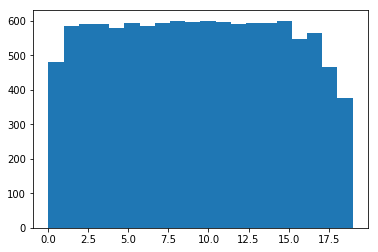

In [11]:
plt.hist(y_test,bins=20)
plt.show()

In [11]:
max_sentence_num=1

In [12]:
max_sentence_length=20

In [13]:
n_classes=20

In [14]:
vec_dim=1

In [15]:
adjusted_train = data_reshape(X_train, max_sentence_num, max_sentence_length,dim=vec_dim)
del X_train
adjusted_train.shape

(11314, 1, 20, 1)

In [16]:
id_max=int(max([num for data in adjusted_train for word in data for num in word])[0])+1
id_max

209607

In [17]:
adjusted_test = data_reshape(X_test, max_sentence_num, max_sentence_length,dim=vec_dim)
del X_test
adjusted_test.shape

(11314, 1, 20, 1)

In [18]:
ans_train = np.zeros((len(y_train), n_classes),dtype=np.float32)
for i, yi in enumerate(y_train):
    ans_train[i, yi] = 1

ans_test = np.zeros((len(y_test), n_classes))
for i, yi in enumerate(y_test):
    ans_test[i, yi] = 1

In [19]:
ans_train.shape, ans_test.shape

((11314, 20), (11314, 20))

In [28]:
embedding_dim=vec_dim
n_hidden=50
batch_size=32

In [29]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class AttentionLayer(Layer):

    def __init__(self,n_hidden, **kwargs):
        self.n_hidden = n_hidden
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.importance_vector=K.ones((2*self.n_hidden,))
        super(AttentionLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self,states):
        u=Dense(2*self.n_hidden,activation='tanh')(states)

        a=K.exp(u*self.importance_vector)
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        weighted_input=a*states
        return weighted_input

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_hidden*2)
    
    def get_config(self):
        config = {'n_hidden': self.n_hidden}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [30]:
def encoder(input_layer,n_hidden):
    input_layer=AlphaDropout(0.5)(input_layer)
    enc_f,state_f = GRU(units=n_hidden,recurrent_activation='hard_sigmoid',return_sequences=True,return_state=True)(input_layer)
    enc_b,state_b = GRU(units=n_hidden,recurrent_activation='hard_sigmoid',return_sequences=True,return_state=True, go_backwards=True)(input_layer)
    states = Concatenate(axis=-1)([state_f,state_b])
    return AttentionLayer(n_hidden)(states)

In [31]:
emb_inside_network_dim=100
def fn():
    input_layer = Input(shape=(max_sentence_num,max_sentence_length,embedding_dim))
    emb=Embedding(id_max,emb_inside_network_dim,input_length=max_sentence_length)(input_layer)
    emb=Reshape((max_sentence_num,max_sentence_length,emb_inside_network_dim))(emb)
    
    normalized=BatchNormalization()(emb)
#     normalized=emb
    
    reshaped_input=Reshape((max_sentence_num*max_sentence_length,emb_inside_network_dim))(normalized)
    word_encode=Reshape((max_sentence_num,-1))(encoder(reshaped_input,n_hidden))
    
    normalized=BatchNormalization()(word_encode)
#     normalized=word_encode

    sentence_encode=encoder(normalized,n_hidden)

    output_layer=Dense(n_classes,activation='softmax')(sentence_encode)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    opt=optimizers.Adam(lr=0.01,amsgrad=True)
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])
    return model

In [32]:
class TestCallback(Callback):
    # https://github.com/keras-team/keras/issues/2548
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [33]:
# from keras.utils import plot_model
# plot_model(fn(), to_file='model_id.png')

In [34]:
model=fn()

In [35]:
h=model.fit(x=adjusted_train,y=ans_train,batch_size=batch_size,epochs=10000,callbacks=[TestCallback((adjusted_test,ans_test)),History()])

Epoch 1/10000
11314/11314 [==============================] - 143s 13ms/step - loss: 2.9518 - acc: 0.0726

Testing loss: 2.855180840199757, acc: 0.09342407636622331

Epoch 2/10000
11314/11314 [==============================] - 111s 10ms/step - loss: 2.8308 - acc: 0.0902

Testing loss: 2.737325295302816, acc: 0.10261622768383429

Epoch 3/10000
11314/11314 [==============================] - 102s 9ms/step - loss: 2.7497 - acc: 0.1032

Testing loss: 2.6253999406970685, acc: 0.11101290436758893

Epoch 4/10000
11314/11314 [==============================] - 92s 8ms/step - loss: 2.6849 - acc: 0.1070

Testing loss: 2.6062617435121527, acc: 0.11110129044452952

Epoch 5/10000
11314/11314 [==============================] - 94s 8ms/step - loss: 2.6291 - acc: 0.1145

Testing loss: 2.50831069220539, acc: 0.13363973837986587

Epoch 6/10000
11314/11314 [==============================] - 95s 8ms/step - loss: 2.5842 - acc: 0.1228

Testing loss: 2.4811821962932785, acc: 0.1419480289985334

Epoch 7/10000
11

KeyboardInterrupt: 

In [ ]:
plt.plot(h.history['acc'])
plt.show()

plt.plot(h.history['loss'])
plt.show()

In [ ]:
model.evaluate(adjusted_test,ans_test)

In [236]:
from keras.models import load_model,model_from_config,Model

In [237]:
model.save('test.h5')

In [238]:
test_model=load_model('test.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [239]:
test_model.evaluate(adjusted_test,ans_test)

11314/11314 [==============================] - 3s 247us/step


[2.576667668437165, 0.16837546404794224]

In [240]:
test_model.fit(adjusted_train,ans_train,callbacks=[TestCallback((adjusted_test,ans_test)),History()])

Epoch 1/1
11314/11314 [==============================] - 94s 8ms/step - loss: 2.6357 - acc: 0.1191

Testing loss: 2.4944132336125433, acc: 0.15343821814472397

